# Period of a Pendulum

We begin our exploration of *computational physics* with an example from mechanics.  We will consider the motion of a pendulum.  

Imagine a pendulum of length $L$ is pulled up to make an angle $\theta$ with respect the the vertical.  

<img src="https://docs.google.com/drawings/d/e/2PACX-1vTwUJDECXEo0ZeyJ-i5zonaMAytMBHm8IfrIwfRnYMoiTKyvSUGirVm9lXpy63JJHaUsopfbYRRZ74J/pub?w=877&amp;h=718">

The component of the graviational force which is in the direction of motion is $F_\parallel=-m g \sin(\theta)$.  The speed of the bob is $v=L d\theta/dt$.  Thus we get equations of motion

\begin{align}
\frac{d \theta}{dt}&= \frac{v}{L} \\
m \frac{d v}{dt}&=-m g \sin(\theta)
\end{align}

We know the pendulum will swing back and forth.  We want to calculate its period.

The classic approach is to use energy arguments.  The kinetic energy of the pendulum is
$$
T=\frac{1}{2}m v^2
$$
The potential energy is
$$
U=-mgL \cos(\theta)
$$
Hend the total energy is
$$
E=\frac{1}{2}m v^2-mgL \cos(\theta).
$$
Since the total energy is conserved we can solve this for the velocity:
$$
v = \sqrt{\frac{2 E}{m} +2 gL \cos(\theta)}
$$
Our argument is slightly simpler if we note that the energy can be related to the maximum angle that the pendulum reaches, $\theta_m$, so:
$$
v = \sqrt{2 g L}\sqrt{\cos(\theta)-\cos(\theta_m)}
$$
Next we note that $v=Ld\theta/dt$ and hence
$$
\frac{d\theta}{dt}=
\sqrt{\frac{2g}{L}}
\sqrt{\cos(\theta)-\cos(\theta_m})
$$

We then note that a quarter period is the time it takes for the pendulum to rise from $\theta=0$ to $\theta=\theta_m$, and hence
$$
\frac{T}{4}=\int_{t_0}^{t_m}\!dt=\sqrt{\frac{L}{2g}}\int_0^{\theta_m}\frac{d\theta}{\sqrt{\cos(\theta)-\cos(\theta_m)}}
$$

This integral is an *elliptic integral*.  It has no closed form in terms of more elementary functions.  Thus we need to develop numerical methods to evaluate it.

The task of evaluating integrals is known as *quadratures*.

# Adimensionalizing

A good first step in any numerical calculation is to *adimensionalize* your equations.  This is actually a good step in analytic work as well.

We will learn how to systematically do this, but here I know that for small amplitudes the period of a pendulum is 
$$
T_{0}=2\pi \frac{L}{g}.
$$
This it makes sense for us to calculate
$$
\bar T =\frac{T}{T_0}=\frac{1}{2\pi}\frac{1}{\sqrt{2}}\int_0^{\theta_m}\frac{d\theta}{\sqrt{\cos(\theta)-\cos(\theta_m)}}
$$

The angle $\theta_m$ is already dimensionless, so we can leave it as-is.

# Strategies

We have several strategies we could pursue now:

1. Type into google "Numerical Integration in Julia".  Download the right package and do the integral.
2. Write our own integrator.

Both are useful.  The advantage of the package is that it will probably get us results sooner.  The advantage of writing our own is that we can tweak it to meet our needs.  Also, we will learn a lot from writing the integrator.

Another thing to consider is if we want to write a function which does this particular integral, or a general purpose one.  Lets go for a general purpose integrator, as that will be more useful.

# Simple approaches to numerical quadratures

<a href="http://numerical.recipes/book.html">Chapter 4 of Numerical Recipies:</a>

The basic idea with most quadrature approaches is to break the integral into discrete segments, and then approximate the integral on each of those segments.  One straightforward approach is the "trapezoid rule" where one breaks each segment into trapezoids:

In [1]:
using Interact,Plots,LaTeXStrings #load in visualization software

WebIO._IJuliaInit()

In [14]:
"""
    showtrapezoids(f,range=(0,1),n=5;opts...)

Illustrates trapezoid rule by plotting the function `f` over the range specified by `range`.
Show `n` trapezoids overlayed.  Passes on options `opts` to the plot command.
"""
function showtrapezoids(f,range=(0,1),n=5;opts...)
    # define variables
    xmin=range[1]
    xmax=range[2]
    dx=2*pi/50
    # Create basic plot of function
    plt=plot(f,xmin,xmax,xlabel="x",ylabel="f",legend=false,show=false,opts...)
    #
    # Draw trapezoids
    #
    function trapezoid(j)
        width=(xmax-xmin)/n
        x1=(j-1)*width
        x2=j*width
        y1=f(x1)
        y2=f(x2)
        Shape([x1, x1, x2, x2],[0,y1,y2,0])
    end
    for j in 1:n
        plot!(trapezoid(j),opacity=0.2)
    end
    plt
end

showtrapezoids

In [13]:
f(x)=cos(x)^2+0.2
@manipulate for n in 1:10
    p=showtrapezoids(f,(0,pi/2),n)
    #display(p)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["n"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 10, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(5), nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/emueller/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/emueller/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/emueller/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), Asset("css", nothing, "/Users/emueller/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), Asset("css", nothing, "/Users/emueller/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x000000010985e720, Task (runnable) @0x000000010985e720), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (2, 10805396944, 4)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"6551208333654341736\",\"i

# Naive implementation of trapezoid rule

Lets not worry about efficiency, and write the simplest implementation of the trapezoid rule that we can think of.  We will make this more efficient later -- but this version is already fast enough for our purposes.

In [22]:
function naive_trap(f,range,n)
    result=0.
    xmin=range[1]
    xmax=range[2]
    dx=(xmax-xmin)/n
    for j in 1:n
        x1=xmin+(j-1)*dx
        x2=x1+dx
        result+= (f(x2)+f(x1))*dx/2
    end
    return result
end

naive_trap (generic function with 1 method)

In [37]:
testf(x)=x^3
naive_trap(testf,(0,1),10)

0.25250000000000006

Notationally that is fine -- but for things like this it is nice to be able to pass around "pure functions" or "lambda functions" or "anonymous functions"  

In [40]:
naive_trap(x->x^3,(0,1),10)

0.25250000000000006

In that expression, `x->x^3` is short-hand for creating the function `testf`, and then inserting it into the function call

In [41]:
(x->x^2)(4)

16

How big of `n` should we use?

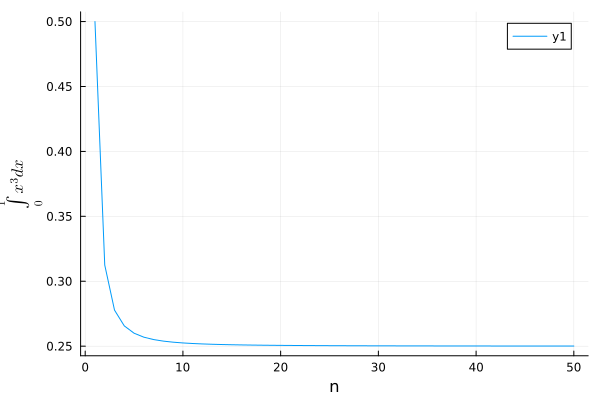

In [52]:
nvals=1:50
tvals=[naive_trap(x->x^3,(0,1),n) for n in nvals]
plot(nvals,tvals,xlabel="n",ylabel=L"$\int_0^1x^3dx$")

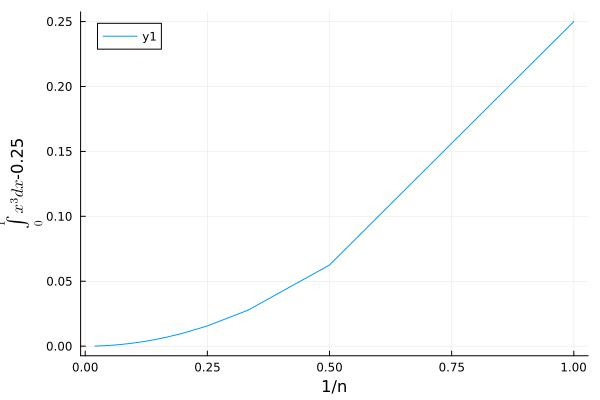

In [56]:
plot(1 ./nvals,tvals.-0.25,xlabel="1/n",ylabel=L"$\int_0^1x^3dx$-0.25")

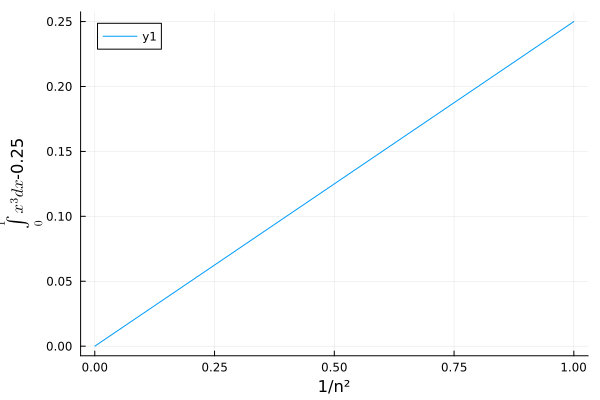

In [60]:
plot(1 ./nvals.^2,tvals.-0.25,xlabel="1/n²",ylabel=L"$\int_0^1x^3dx$-0.25")

Aparently the error scales as $1/n^2$

# Big O Notation

We will often say that a function $f_n$ scales as $O(n^\alpha)$ as $n\to\infty$.  This means that there exists an integer $N$ and a constant $C$ such that $|f_n|\leq Cn^\alpha$ for all $n>N$.  Note that this is an upper bound.  

In this course we will write $f_n\sim n^\alpha$ as $n\to\infty$ to mean that there exists a constant $C$ such that $|f_n- n^\alpha|$ vanishes as $n\to\infty$.

We will often leave off the "$n\to\infty$" part of the statement.  Sometimes we will take a different limit -- for example we could say $f(x)=O(x^{-2})$ as $x\to0$, to mean that for small $x$ $|f(x)|$ is bounded from above by a function proportional to $x^{-2}$.    

We can also talk about $O(g(x))$ for functions other than power laws.  

# Richardson Extrapolation

If we know that the error in the trapezoid rule scales as $n^{-2}$ we can do the integral for several values of $n$ and then fit to a function of the form $I_n=I_\infty + \epsilon n^{-2}$ -- extracting a better approximation to the integral.

In [61]:
I4=naive_trap(x->x^3,(0,1),4)

0.265625

In [62]:
I8=naive_trap(x->x^3,(0,1),8)

0.25390625

$$I_n=I_\infty+\epsilon n^{-2}$$
We then multiply by $n^2$,
$$n^2 I_n=n^2 I_\infty+\epsilon$$
We then take two values of $n$ -- say $n=4$ and $n=8$.
\begin{align}
4^2 I_4 &= 4^2 I_\infty+\epsilon\\
8^2 I_8 &= 8^2 I_\infty+\epsilon
\end{align}
Subtract these
$$
8^2 I_8-4^2 I_4= (8^2-4^2) I_\infty
$$
or
$$
I_\infty= \frac{8^2 I_8-4^2 I_4}{8^2-4^2} =\frac{2^2 I_8-I_4}{2^2-1}
$$

In [65]:
(2^2*I8-I4)/(2^2-1)

0.25

This was exact in this case because of the form of the integrand.  In general, if we used $I_n$ and $I_{n/2}$ we would still have an error which would scale as $n^{-3}$.  The approximation $I\approx I_n+I_{n/2}$ is known as *Simpson's Rule*

This trick can be repeated.  I can take Simpson's rule with two different $n$'s, and combine them to get an even better approximation to the integral.  This strategy is known as Romberg Integration.

**Caution:** Richardson extrapolation (and Romberg integration schemes) rely on our integrand being smooth.  If it is poorly behaved, then they don't necessarily help. 

# Euler-Maclaurin Summation formula

A good framework for understanding these approximations in the **Euler-Maclaurin Summation Formula**.  Here is a somewhat formal derivation.  This is mostly for my own amusement -- and this *derivation* contains one or two cheats.

We will first remind you about series expansions.  Analytic functions can be written in series, such as
\begin{align}
e^x&=\sum_j \frac{x^j}{j!}\\
\frac{1}{1-x}&=\sum_j x^j.
\end{align}
Such a series is sometimes used to define a set of numbers.  We are going to need the Bernoulli numbers, which are defined by the series
$$
\frac{x}{e^{x}-1}=\sum_j \frac{B_j}{j!} x^j.
$$
One can Brute-force expand the left hand side to get
$B_0=1$, $B_1=-1/2$, $B_2=1/6$, $B_3=0$, $B_4=-1/30,\cdots$  You can easily Google them.



With Bernoulli numbers in hand we will now think about operators that act on the space of functions.  They take in a function, and spit out a new function.  For example, lets intoduce $\Delta$, which is defined by $(\Delta f)(x)=f(x+1)-f(x)$.  In Julia we can create this operator with

In [66]:
Δ(f)=(x->f(x+1)-f(x))

Δ (generic function with 1 method)

or if that notation makes you queezy, you could also write

In [ ]:
function Δ(f)
    function g(x)
        return f(x+1)-f(x)
    end
    return g
end

In [69]:
f1(x)=x^2
f2=Δ(f1)
(f1(5)-f1(4),f2(4))

(9, 9)

We will next introduce $\Sigma$.  It again maps functions onto functions.  We will only need to define what it does to functions on integers.  It is defined for positive integers $x$ as
$$
(\Sigma f)(x)=\sum_{n=0}^{x-1} f(n)
$$

I won't write a function that does this, but you can imagine how to do it.  I claim that $\Delta\Sigma=I$, where $I$ is the identity matrix.  To prove this one writes
\begin{align}
(\Delta\Sigma f)(x)&=(\Sigma f)(x+1)-(\Sigma f)(x)\\
&=\sum_{n=0}^x f(n) - \sum_{n=0}^{x-1} f(x).
\end{align}
All of the terms cancel except the last, which gives, $(\Delta\Sigma f)(x)=f(x)$, which shows that $\Delta\Sigma$ is the identity operator.  This makes sense, $\Delta$ and $\Sigma$ are inverses of each-other.

In the other order, however, we find $(\Sigma\Delta f)(x)=f(x)-f(0)$, so the order matters.

Next we introduce two more operators
\begin{align}
(\partial f)(x)&=f'(x)\\
(\smallint  f)(x)&=\int_0^x f(y)dy.
\end{align}
The fundamental theorem of calculus states that $\partial\smallint=  I.$  As with the $\Sigma$ and $\Delta$, if we reverse the order we get $(\smallint\partial f)(x)=f(x)-f(0)$.

We now turn to Taylor's theorem,
\begin{align}
f(x+1)&=f(x)+\sum_{j=1}^\infty \frac{(\partial^n f)(x)}{n!}\\
&= (e^\partial f)(x).
\end{align}
Thus Taylor's theorem can be written as $\Delta=e^{\partial}-1$

Putting this together with our previous result, $\Delta\Sigma=I$ yields
\begin{align}
\Sigma=\frac{1}{e^\partial-1}.
\end{align}
We will now multiply the right hand side by $I=\smallint \partial $ to find
\begin{align}
\Sigma=\smallint\frac{\partial}{e^\partial-1} .
\end{align}
Finally we expand the right hand side in a Taylor series:
\begin{align}
(\Sigma f)(x)&=\left(\smallint\sum_{j=0}^\infty \frac{B_j}{j!} \partial^j f\right)(x)\\
&=(\smallint f)(x) + \sum_{j=1}^\infty  \frac{B_j}{j!} \left[(\partial^{j-1} f)(x)-
(\partial^{j-1} f)(0)
\right]
\end{align}
which can be reorganized into the Euler-Maclauren summation formula
\begin{align}
\int_0^x f(y) dy &= \sum_{y=0}^{x-1} f(y) - \sum_{j=1}^\infty \frac{B_j}{j!} \left[(\partial^{j-1} f)(x)-
(\partial^{j-1} f)(0)
\right]\\
&= \sum_{y=0}^{x-1} f(y) + \frac{1}{2}[f(x)-f(0)] + \frac{B_2}{2} [f'(x)-f'(0)]+\cdots
\end{align}
The first two terms give you the trapezoid rule.  Subsequent terms give you corrections in terms of derivatives of the function at the bounds.

This may seem strange that knowledge about the behaviour of the function at the boundaries so strongly constrain the integral.  This is a peculiarity of analytic functions.

# Improving our trapezoid rule integrator

In [ ]:
function naive_trap(f,range,n)
    result=0.
    xmin=range[1]
    xmax=range[2]
    dx=(xmax-xmin)/n
    for j in 1:n
        x1=xmin+(j-1)*dx
        x2=x1+dx
        result+= (f(x2)+f(x1))*dx/2
    end
    return result
end

**Inefficiencies:** 

* The function `f` is evaluated twice at every location. 
* We have `2n` muliplications by `dx`.  
* We don't use Richardson   

**Inconveniences:** 

* We need to specify `n`, the number of trapezoids, 
* We don't know how accurate our result is

Lets solve the inconvenience, but not worry about the inefficiencies yet.  It will be easy enough to fix those later.  What I would really like to do is implement a strategy from *Numerical Recipies* which does the Trapezoid rule with dynamic step sizes

The reason I want to go through it, is that it introduces some useful computer science -- namely using *objects*.  *Objects* are the nouns of programs -- just as *functions* are the verbs.

This approach uses subdivides the integral into $n=2^m$ trapezoids.  We are going to sequentially increase $m$ until we achieve our desired accuracy.  In order to do this we define an object `trap_data` which stores information about the integral that you are using, and an interim result.

In [76]:
"""
    trapdata(f,range)

stores the intermediate information for our trapezoid rule. 

Fields:
    f       # store the function we are integrating
    range   # store the range (a,b)
    val     # trapezoid rule integral at current depth, m
    m       # depth -- number of trapezoids = 2ᵐ

To increase the depth use command `subdivide!` or `subdivide`.

"""
mutable struct trap_data
    f       # store the function we are integrating
    range   # store the range (a,b)
    val     # trapezoid rule integral at current depth, m
    m ::Integer      # depth -- number of trapezoids = 2ᵐ
    function trap_data(f,range)
        new(f,range,(f(range[1])+f(range[2]))/2,0)
    end
end

function subdivide!(data ::trap_data)
    # Extract needed info from `data`
    f=data.f
    m=data.m+1
    result=zero(data.val)
    (a,b)=data.range
    # Width of new rectangles
    dx=(b-a)/2^m
    for x in dx:dx*2:dx*(2^m-1)
        result+=f(x)
    end
    result=(result*dx)+data.val/2
    # Update data
    data.m=m
    data.val=result
end



subdivide! (generic function with 1 method)

In [77]:
t1=trap_data(x->x^3,(0,1))

trap_data(var"#66#67"(), (0, 1), 0.5, 0)

In [78]:
t1.val

0.5

In [81]:
naive_trap(x->x^3,(0,1),1)

0.5

In [79]:
subdivide!(t1)
t1.val

0.3125

In [82]:
naive_trap(x->x^3,(0,1),2)

0.3125

In [80]:
subdivide!(t1)
t1.val

0.265625

In [84]:
naive_trap(x->x^3,(0,1),4)

0.265625

In [85]:
"""
    copy(data::trap_data)

is a shallow copy of the original data.  It reuses the pointer to the function `f`
and the range `range`.
"""
function copy(data::trap_data)
    newdata=trap_data(data.f,data.range)
    newdata.m=data.m
    newdata.val=data.val
    return newdata
end

function subdivide(data ::trap_data)
    newdata=copy(data)
    subdivide!(newdata)
    return newdata
end

subdivide (generic function with 1 method)

In [86]:
t2=subdivide(t1)

trap_data(var"#66#67"(), (0, 1), 0.25390625, 3)

In [87]:
t2.val

0.25390625

In [88]:
t1.val

0.265625

In [99]:
function nrtrap(f,range;eps=1E-10,max_divisions=20,debug=false)
    data=trap_data(f,range)
    for j in 1:max_divisions
        oldval=data.val
        subdivide!(data)
        val=data.val
        if abs(val-oldval)<eps*abs(oldval) || (val==0 && oldval==0)
            if debug
                print("converged after "*string(j)*" iterations")
            end
            return val
        end
    end
    error("Did not converge to precision "*string(ϵ)*
          "after "*string(j)*" subdivisions."*
          "previous 2 results: ("*string(oldval)*
          ","*string(val)*")")
end

nrtrap (generic function with 1 method)

In [101]:
nrtrap(x->x^3,(0,1),debug=true)

converged after 18 iterations

0.25000000000363815

In [102]:
nrtrap(x->x^4,(0,1),debug=true)

converged after 18 iterations

0.20000000000485063

In [98]:
2^18

262144

In [ ]:
function romburg(f,range;k=5,eps=1E-10,max_divisions=20,debug=false)
    data=trap_data(f,range)
    for j in 1:max_divisions
        oldval=data.val # contains 2^(j-1) rectangles
        subdivide!(data)
        val=data.val # contains 2^(j-)
        #